# Оценка риска ДТП по выбранному маршруту движения

Нужно понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов, а также создать модель, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. 

На основе модели нужно исследовать основные факторы ДТП и понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
- Возможно ли создать адекватную систему оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Содержание
 - [Шаг 1. Подключение к базе. Загрузка таблицы sql](#getting-data)
 - [Шаг 2. Первичное исследование таблиц](#exploratory-data-analysis)
 - [Шаг 3. Статистический анализ факторов ДТП](#statistical-factor-analysis)
 - [Шаг 4. Создание модели для оценки водительского риска](#model-creation)
 - [Шаг 5. Поиск лучшей модели и анализ важности факторов ДТП](#best-model-search)
 - [Шаг 6. Проверка лучшей модели в работе](#best-model-test)
 - [Шаг 7. Выводы](#general-conclusion)

Импортируем полезные библиотеки, которые пригодятся нам в дальнейшем

In [1]:
# !pip install -U scikit-learn
# !pip install optuna
# !pip install phik

import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import phik
import psycopg2
import optuna
from phik.report import plot_correlation_matrix
from IPython.core.display import display, HTML
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMClassifier, plot_importance

Объявим константы и зададим параметры по умолчанию, которые понадобятся нам в дальнейшем

In [2]:
RANDOM_STATE = 144210
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
plt.rc('figure', figsize=(18, 6))                                  # size of the figure
set_config(display='diagram')

<a name="getting-data"></a>
## Шаг 1. Подключение к базе. Загрузка таблицы sql

In [3]:
database_config = {
    'user': 'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'dbname': 'data-science-vehicle-db'
} 
 
conn = psycopg2.connect(**database_config) 
cur = conn.cursor() 

<a name="exploratory-data-analysis"></a>
## Шаг 2. Первичное исследование таблиц

#### Проверим соответствует ли количество таблиц условию задачи:

In [4]:
cur.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
table_names = pd.Series(data=[data_tuple[0] for data_tuple in cur.fetchall()])
table_names

0      case_ids
1    collisions
2       parties
3      vehicles
dtype: object

#### Проверим все ли таблицы имеют набор данных:

In [5]:
table_not_empty = pd.Series(index=table_names.values, dtype='bool')
for table_name in table_names.values:
    cur.execute(f"SELECT EXISTS(SELECT 1 FROM {table_name})")
    table_not_empty[table_name] = cur.fetchall()[0][0]
    
table_not_empty

case_ids      True
collisions    True
parties       True
vehicles      True
dtype: bool

#### Проверим имеется ли общий ключ для связи таблиц:

In [6]:
shared_columns = None
for table_name in table_names.values:
    cur.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name}'")
    result = set(data_tuple[0] for data_tuple in cur.fetchall())
    shared_columns = result if shared_columns is None else shared_columns.intersection(result)
    
shared_columns

{'case_id'}

#### Краткий вывод:
- количество таблиц в базе данных соответствует условию задачи
- все таблицы имеют не пустой набор данных
- у таблиц имеется общий ключ для связи — `case_id`

<a name="statistical-factor-analysis"></a>
## Шаг 3. Статистический анализ факторов ДТП

#### Выясним в какие месяцы происходит наибольшее количество аварий:

In [7]:
cur.execute("SELECT EXTRACT('MONTH' FROM collision_date), COUNT(*) FROM collisions GROUP BY EXTRACT('MONTH' FROM collision_date)")

season_name = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
crashes = pd.DataFrame(cur.fetchall(), columns=['month', 'crashes'])
crashes['season'] = crashes['month'].apply(lambda x: season_name[x % 12 // 3 + 1])
crashes['month'] = crashes['month'].apply(lambda i: calendar.month_name[int(i)])
crashes

,month,crashes,season
0,January,132044,Winter
1,February,128858,Winter
2,March,139581,Spring
3,April,130180,Spring
4,May,130316,Spring
5,June,102594,Summer
6,July,102227,Summer
7,August,104089,Summer
8,September,105159,Autumn
9,October,112237,Autumn


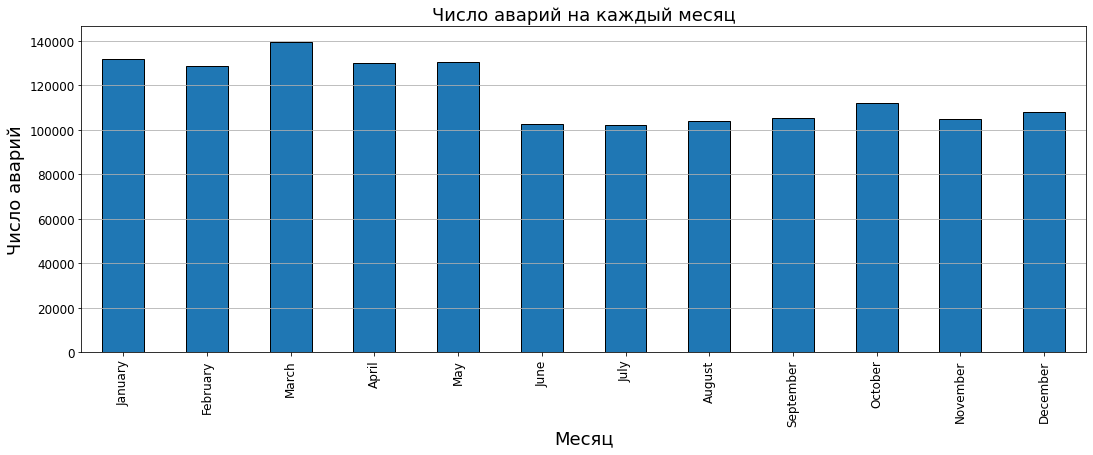

In [8]:
ax = crashes.set_index('month')['crashes'].plot(kind='bar', edgecolor='black')
ax.grid(axis='y')
ax.set_xlabel('Месяц')
ax.set_ylabel('Число аварий')
ax.set_title('Число аварий на каждый месяц');

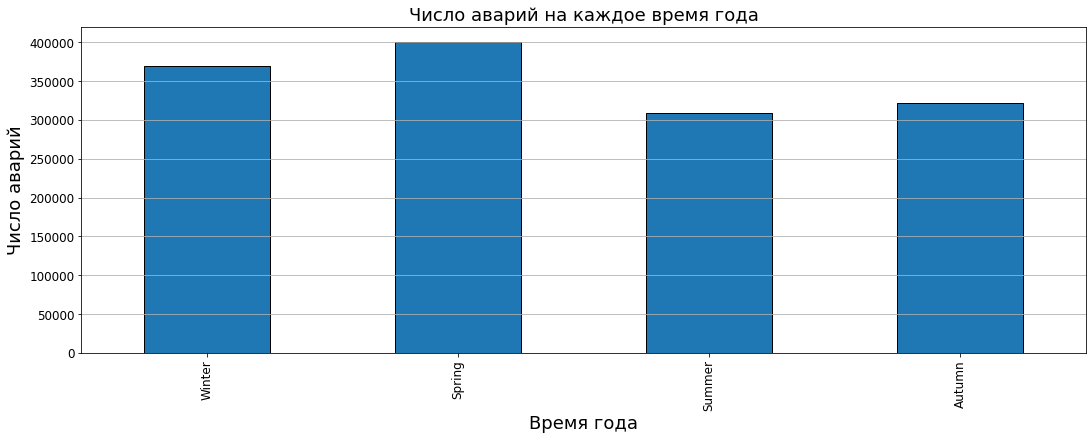

In [9]:
ax = crashes.groupby('season')['crashes'].sum()[['Winter', 'Spring', 'Summer', 'Autumn']].plot(kind='bar', edgecolor='black')
ax.grid(axis='y')
ax.set_xlabel('Время года')
ax.set_ylabel('Число аварий')
ax.set_title('Число аварий на каждое время года');

Можно заметить, что зимой и весной число аварий как правило больше, чем во второй половине года. Возможно это как-то связано с таянием снега и состоянием дороги `road_surface`. В первой половине года дорога как правило мокрая или заснеженная, а летом и осенью наоборот сухая. Также на это может влиять погода `weather_1` или освещение `lighting`

In [10]:
# Функция генерирует два набора данных — все значения столбца column из таблицы collisions за первую половину года и все значения за вторую половину года
def half_year_split(column):
    cur.execute(f"SELECT {column} FROM collisions WHERE EXTRACT('MONTH' FROM collision_date) IN (12, 1, 2, 3, 4, 5)")
    first_half_data = pd.Series([data_tuple[0] for data_tuple in cur.fetchall()], name='first_half_'+column).value_counts(normalize=True)

    cur.execute(f"SELECT {column} FROM collisions WHERE EXTRACT('MONTH' FROM collision_date) BETWEEN 6 AND 11")
    second_half_data = pd.Series([data_tuple[0] for data_tuple in cur.fetchall()], name='second_half_'+column).value_counts(normalize=True)
    
    return first_half_data, second_half_data

# Функция строит графики по двум наборам данных
def generate_bar_plots(data_first, data_seconds):
    ax = plt.subplot()
    data_first.plot(kind='bar', edgecolor='black', color='royalblue', alpha=0.75, ax=ax)
    data_seconds.plot(kind='bar', edgecolor='black', color='orange', alpha=0.5, ax=ax)
    ax.grid(axis='y')
    ax.legend()
    plt.show()

    ax = plt.subplot()
    relative_surface = data_first - data_seconds
    relative_surface.plot(kind='bar', edgecolor='black', color=(relative_surface > 0).map({True: 'g', False: 'r'}), ax=ax)
    ax.grid(axis='y')
    plt.show()

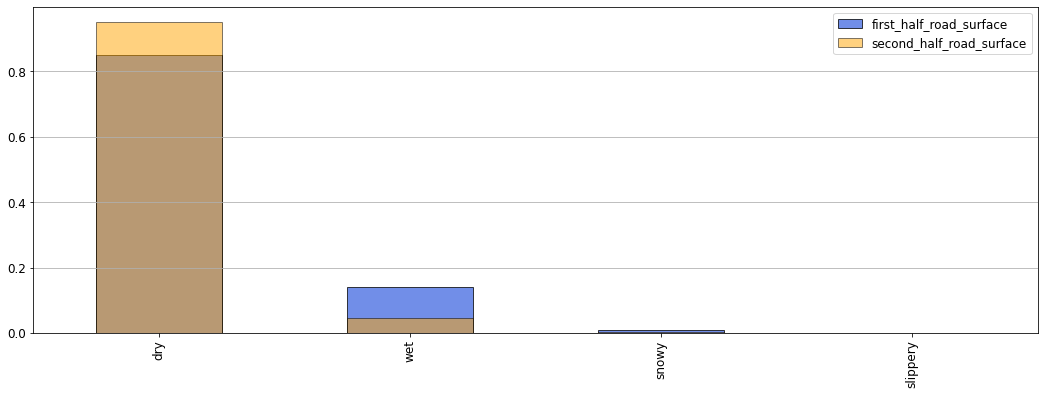

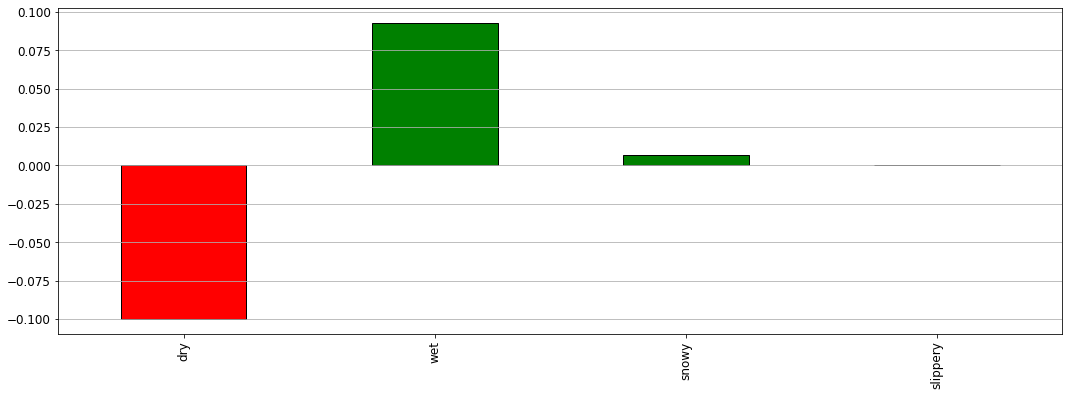

In [11]:
generate_bar_plots(*half_year_split('road_surface'))

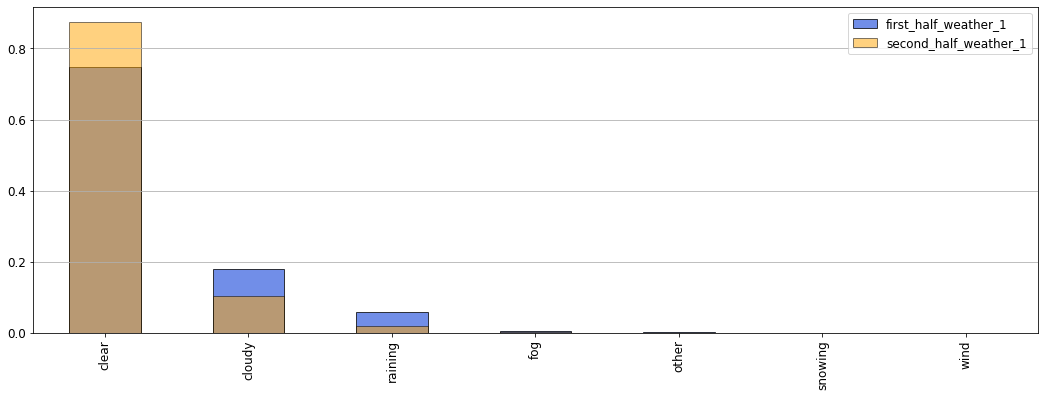

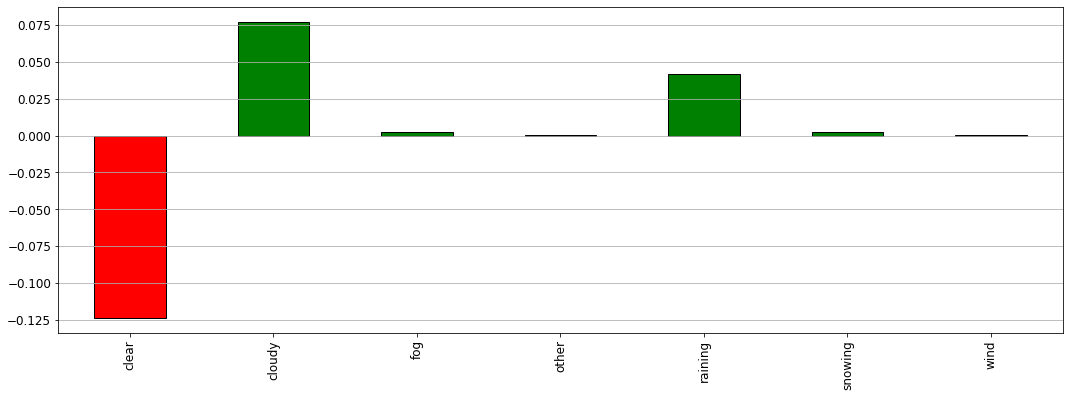

In [12]:
generate_bar_plots(*half_year_split('weather_1'))

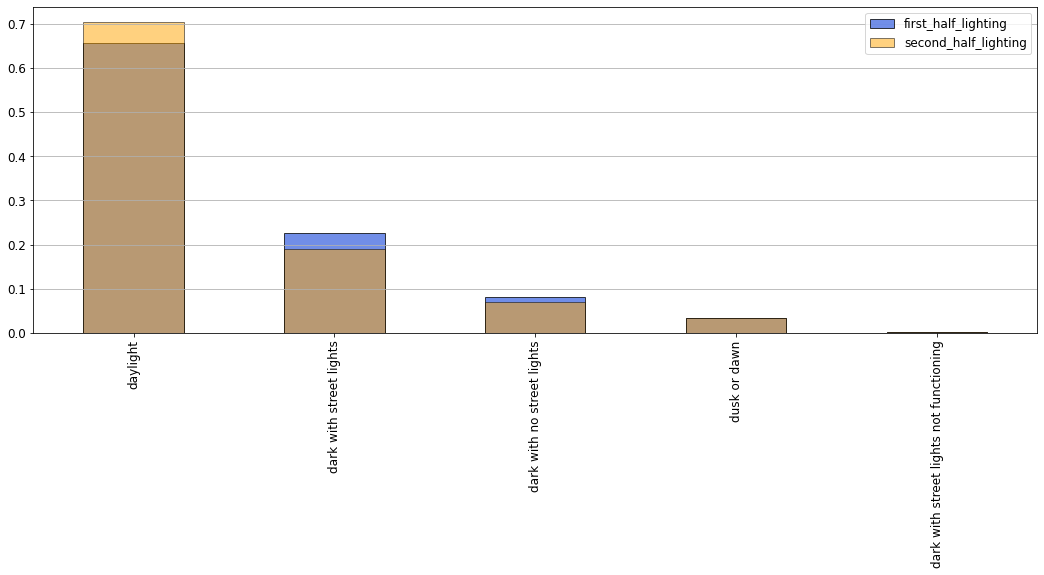

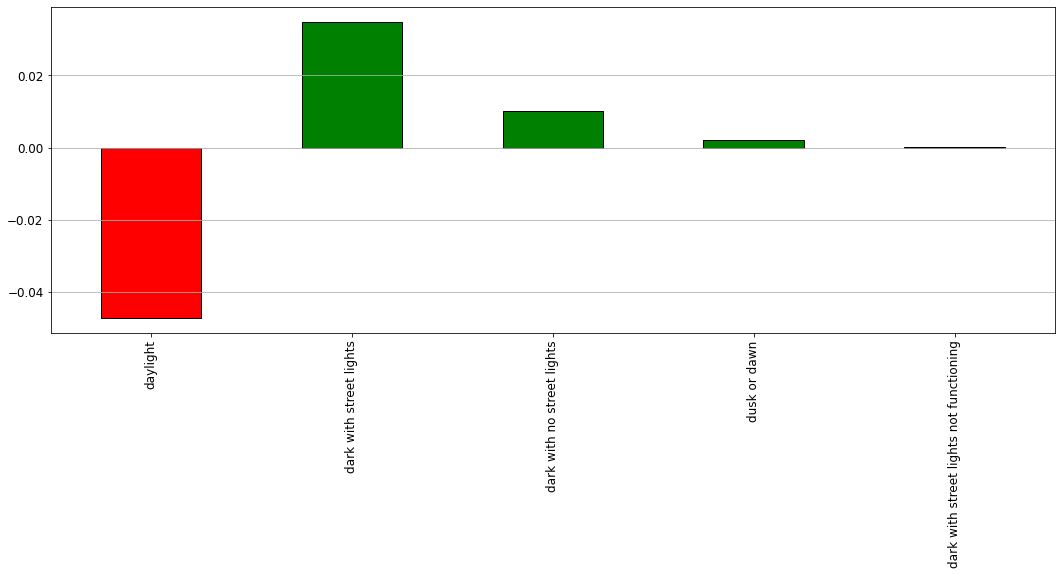

In [13]:
generate_bar_plots(*half_year_split('lighting'))

В первой половине года аварии чаще случаются при мокрой дороге, облачной или дождливой погоде и в тёмное время суток (зимой день короче, а ночь длиннее)

#### Распишем список аналитических задач, которые помогут лучше понять как устроены данные:
- Выясните, как целевое значение `at_fault` связано с остальными столбцами из таблиц
- Выясните, какой самый частый тип аварии `type_of_collision`
- Выясните, как тип коробки передач `vehicle_transmission` взаимосвязан с серьёзностью происшествия `collision_damage`
- Выясните, при каком значении трезвости участника `party_sobriety` в момент ДТП чаще всего водитель становится виновником `at_fault`
- Выясните, есть ли взаимосвязь между наличием телефона `cellphone_in_use` в автомобиле участника ДТП и его виновностью `at_fault`
- Выясните, какое самое частое сочетание типа кузова `vehicle_type` и типа аварии `type_of_collision`

#### Выясним, как тип коробки передач `vehicle_transmission` взаимосвязан с серьёзностью происшествия `collision_damage`:


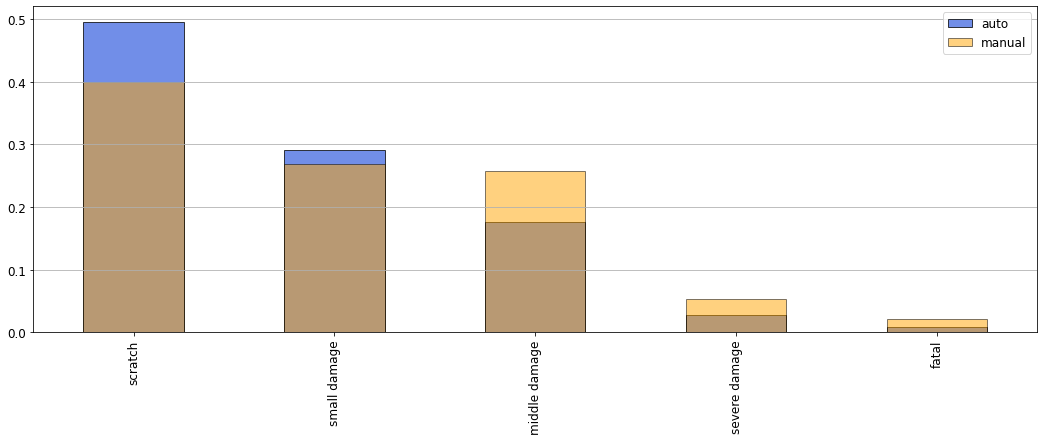

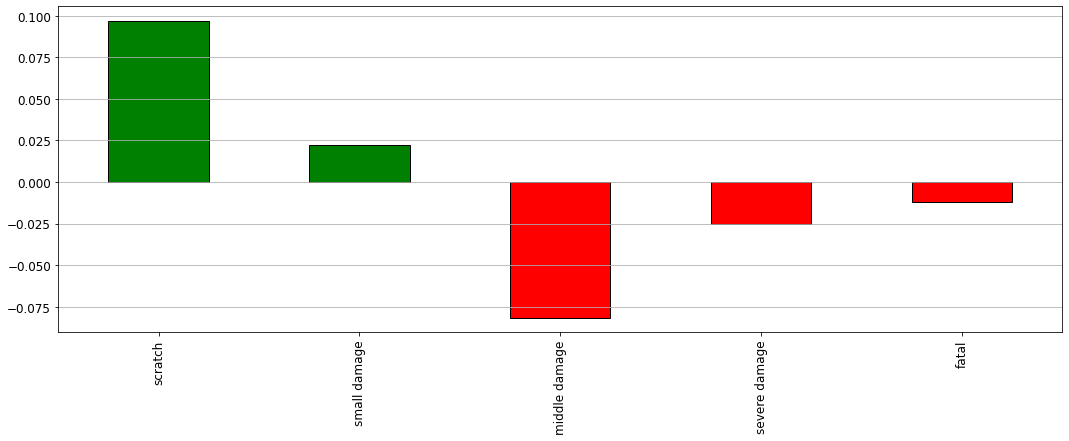

In [14]:
cur.execute("SELECT vehicle_transmission, collision_damage FROM vehicles AS v JOIN collisions AS c ON v.case_id = c.case_id")

result = pd.DataFrame(cur.fetchall(), columns=['vehicle_transmission', 'collision_damage']).set_index('vehicle_transmission')
auto_collision_damage = pd.Series(result.loc['auto', 'collision_damage'].value_counts(normalize=True), name='auto')
manual_collision_damage = pd.Series(result.loc['manual', 'collision_damage'].value_counts(normalize=True), name='manual')
generate_bar_plots(auto_collision_damage, manual_collision_damage)

Автомобили с механической коробкой передач чаще попадают в аварии с более серьезным ущербом (`severe damage`, `fatal`), чем автомобили с автоматической коробкой передач

#### Выясним, какое самое частое сочетание типа кузова `vehicle_type` и типа аварии `type_of_collision`:

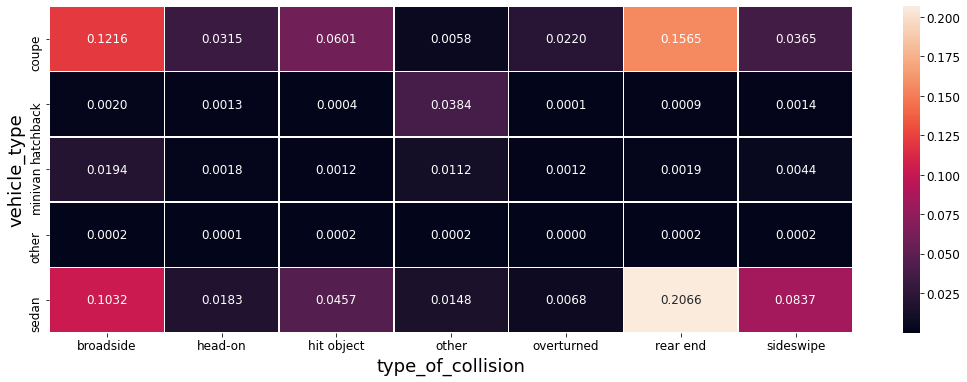

In [15]:
cur.execute("SELECT vehicle_type, type_of_collision FROM collisions AS c LEFT JOIN vehicles AS v ON c.case_id = v.case_id")

result = pd.DataFrame(cur.fetchall(), columns=['vehicle_type', 'type_of_collision'])
sns.heatmap(pd.crosstab(result['vehicle_type'], result['type_of_collision'], normalize=True), annot=True, linewidth=0.5, fmt=".4f");

Более трети всех аварий повреждают заднюю часть автомобиля с типом кузова седан или купе

#### Краткий вывод:
- больше всего аварий случаются в первой половине года (в марте). Возможно это как-то связано с таянием снега и состоянием дороги `road_surface`. В первой половине года дорога как правило мокрая или заснеженная, а летом и осенью наоборот сухая. Также на это может влиять погода `weather_1` или освещение `lighting`
- в первой половине года аварии чаще случаются при мокрой дороге, облачной или дождливой погоде и в тёмное время суток (зимой день короче, а ночь длиннее)
- автомобили с механической коробкой передач чаще попадают в аварии с более серьезным ущербом (`severe damage`, `fatal`), чем автомобили с автоматической коробкой передач
- более трети всех аварий повреждают заднюю часть автомобиля с типом кузова седан (`sedan`) или купе (`coupe`)

<a name="model-creation"></a>
## Шаг 4. Создание модели для оценки водительского риска

### Загрузка данных

#### Подготовим набор данных на основе первичного предположения заказчика:

In [16]:
cur.execute("""
WITH 
    filtered_collisions AS (SELECT * FROM collisions WHERE collision_damage != 'scratch' AND EXTRACT('YEAR' FROM collision_date) = 2012)                             
SELECT 
    fc.case_id, 
    fc.county_city_location,
    fc.county_location,
    fc.distance,
    fc.direction,
    fc.intersection,
    fc.weather_1,
    fc.location_type,
    fc.collision_damage,
    fc.party_count,
    fc.primary_collision_factor,
    fc.pcf_violation_category,
    fc.type_of_collision,
    fc.motor_vehicle_involved_with,
    fc.road_surface,
    fc.road_condition_1,
    fc.lighting,
    fc.control_device,
    fc.collision_date,
    fc.collision_time,
    p.party_number,
    p.party_type,
    p.at_fault,
    p.insurance_premium,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age
FROM filtered_collisions AS fc 
LEFT JOIN parties AS p ON fc.case_id = p.case_id
LEFT JOIN vehicles AS v ON fc.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car'
""")

data = pd.DataFrame(cur.fetchall(), columns=[data_tuple[0] for data_tuple in cur.description])

#### Закроем соединение с базой данных:

In [17]:
cur.close() 
conn.close()

#### Ознакомимся с набором данных. Выведем несколько строк, взятых случайным образом:

In [18]:
data.sample(8, random_state=RANDOM_STATE)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
3624,5609785,1934,los angeles,600.0000,east,0.0000,cloudy,None,small damage,2,...,1,car,1,42.0000,had not been drinking,None,0.0000,None,None,NaN
139297,5613656,0103,alameda,1808.0000,east,0.0000,clear,highway,small damage,2,...,2,car,0,42.0000,had not been drinking,None,0.0000,None,None,NaN
95314,5485766,4313,santa clara,2112.0000,north,0.0000,clear,highway,small damage,2,...,1,car,0,25.0000,had not been drinking,None,0.0000,None,None,NaN
95538,5539865,2106,marin,45.0000,east,0.0000,clear,None,small damage,2,...,1,car,1,44.0000,had not been drinking,None,0.0000,None,None,NaN
90144,5586114,3600,san bernardino,0.0000,None,1.0000,clear,ramp,small damage,2,...,2,car,0,40.0000,had not been drinking,None,0.0000,None,None,NaN
121064,5589730,0701,contra costa,5280.0000,east,0.0000,cloudy,highway,small damage,2,...,1,car,1,80.0000,had not been drinking,None,0.0000,None,None,NaN
129319,5495815,1942,los angeles,2.0000,east,0.0000,clear,None,small damage,1,...,1,car,1,NaN,impairment unknown,G,NaN,None,None,NaN
15681,5631419,5001,stanislaus,810.0000,south,0.0000,clear,highway,small damage,2,...,2,car,0,46.0000,had not been drinking,None,0.0000,None,None,NaN


#### Отобразим информацию для краткого обзора данных:

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      196837 non-null  object 
 1   county_city_location         196837 non-null  object 
 2   county_location              196837 non-null  object 
 3   distance                     196837 non-null  float64
 4   direction                    153975 non-null  object 
 5   intersection                 195850 non-null  float64
 6   weather_1                    196183 non-null  object 
 7   location_type                87357 non-null   object 
 8   collision_damage             196837 non-null  object 
 9   party_count                  196837 non-null  int64  
 10  primary_collision_factor     196098 non-null  object 
 11  pcf_violation_category       193173 non-null  object 
 12  type_of_collision            195280 non-null  object 
 13 

#### Посчитаем количество пропущенных значений:

In [20]:
data.isna().sum()

case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                       42862
intersection                      987
weather_1                         654
location_type                  109480
collision_damage                    0
party_count                         0
primary_collision_factor          739
pcf_violation_category           3664
type_of_collision                1557
motor_vehicle_involved_with       837
road_surface                     1273
road_condition_1                 1143
lighting                          721
control_device                    973
collision_date                      0
collision_time                   1373
party_number                        0
party_type                          0
at_fault                            0
insurance_premium               20230
party_sobriety                   3625
party_drug_physical            171689
cellphone_in

#### Отобразим таблицу с описательной статистикой столбцов:

In [21]:
data.describe()

,distance,intersection,party_count,party_number,at_fault,insurance_premium,cellphone_in_use,vehicle_age
count,196837.0000,195850.0000,196837.0000,196837.0000,196837.0000,176607.0000,171464.0000,54554.0000
mean,662.4782,0.2019,2.1061,1.5077,0.5235,38.9450,0.0236,4.8565
std,7915.2643,0.4014,0.7267,0.6651,0.4994,16.2303,0.1519,3.2345
min,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000
25%,10.0000,0.0000,2.0000,1.0000,0.0000,25.0000,0.0000,3.0000
50%,100.0000,0.0000,2.0000,1.0000,1.0000,36.0000,0.0000,4.0000
75%,500.0000,0.0000,2.0000,2.0000,1.0000,50.0000,0.0000,7.0000
max,1584000.0000,1.0000,12.0000,10.0000,1.0000,105.0000,1.0000,161.0000


#### Отобразим таблицу с попарными корреляциями столбцов:

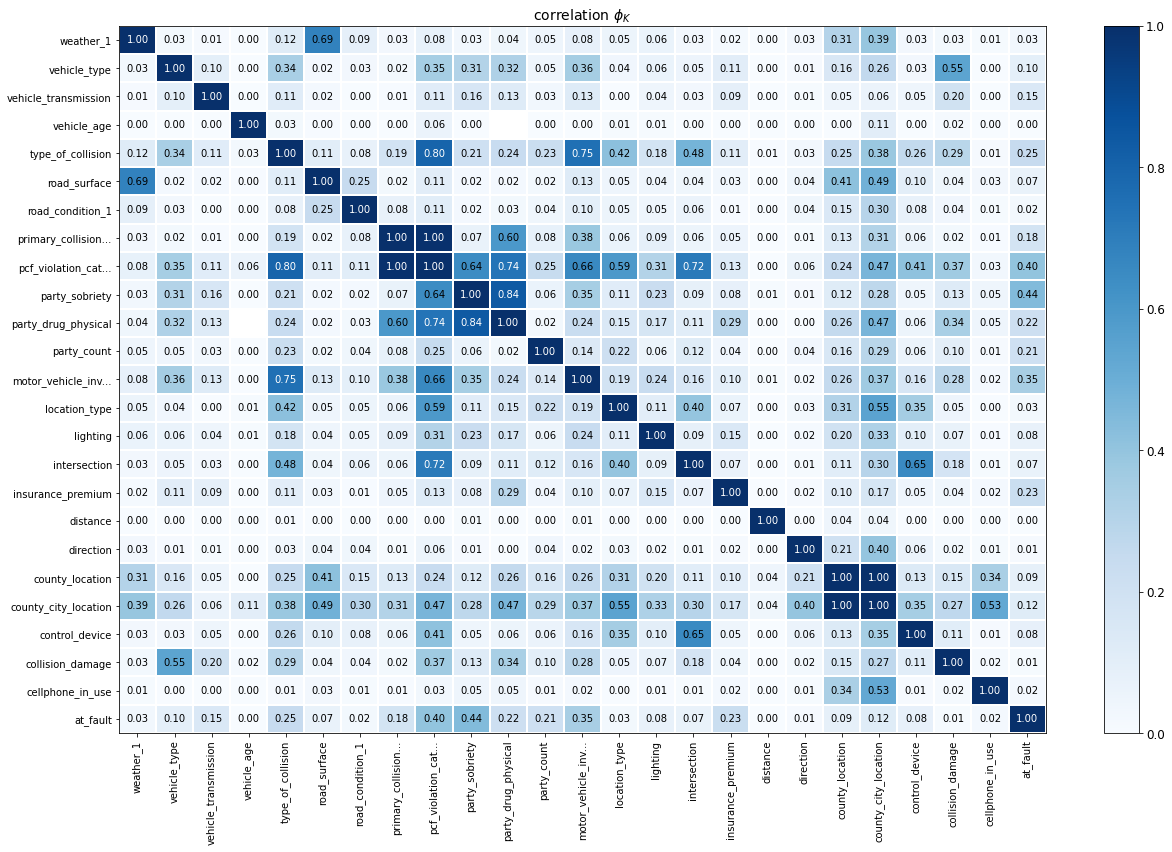

In [22]:
phik_columns = data.columns.difference(['case_id', 'collision_date', 'collision_time', 'party_number', 'party_type'])
phik_overview = data[phik_columns].phik_matrix(interval_cols=['distance', 'party_count', 'party_number', 'insurance_premium', 'vehicle_age'])
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.0,
                        figsize=(18, 12))
plt.tight_layout()

#### Отобразим гистограммы распределений значений столбцов:

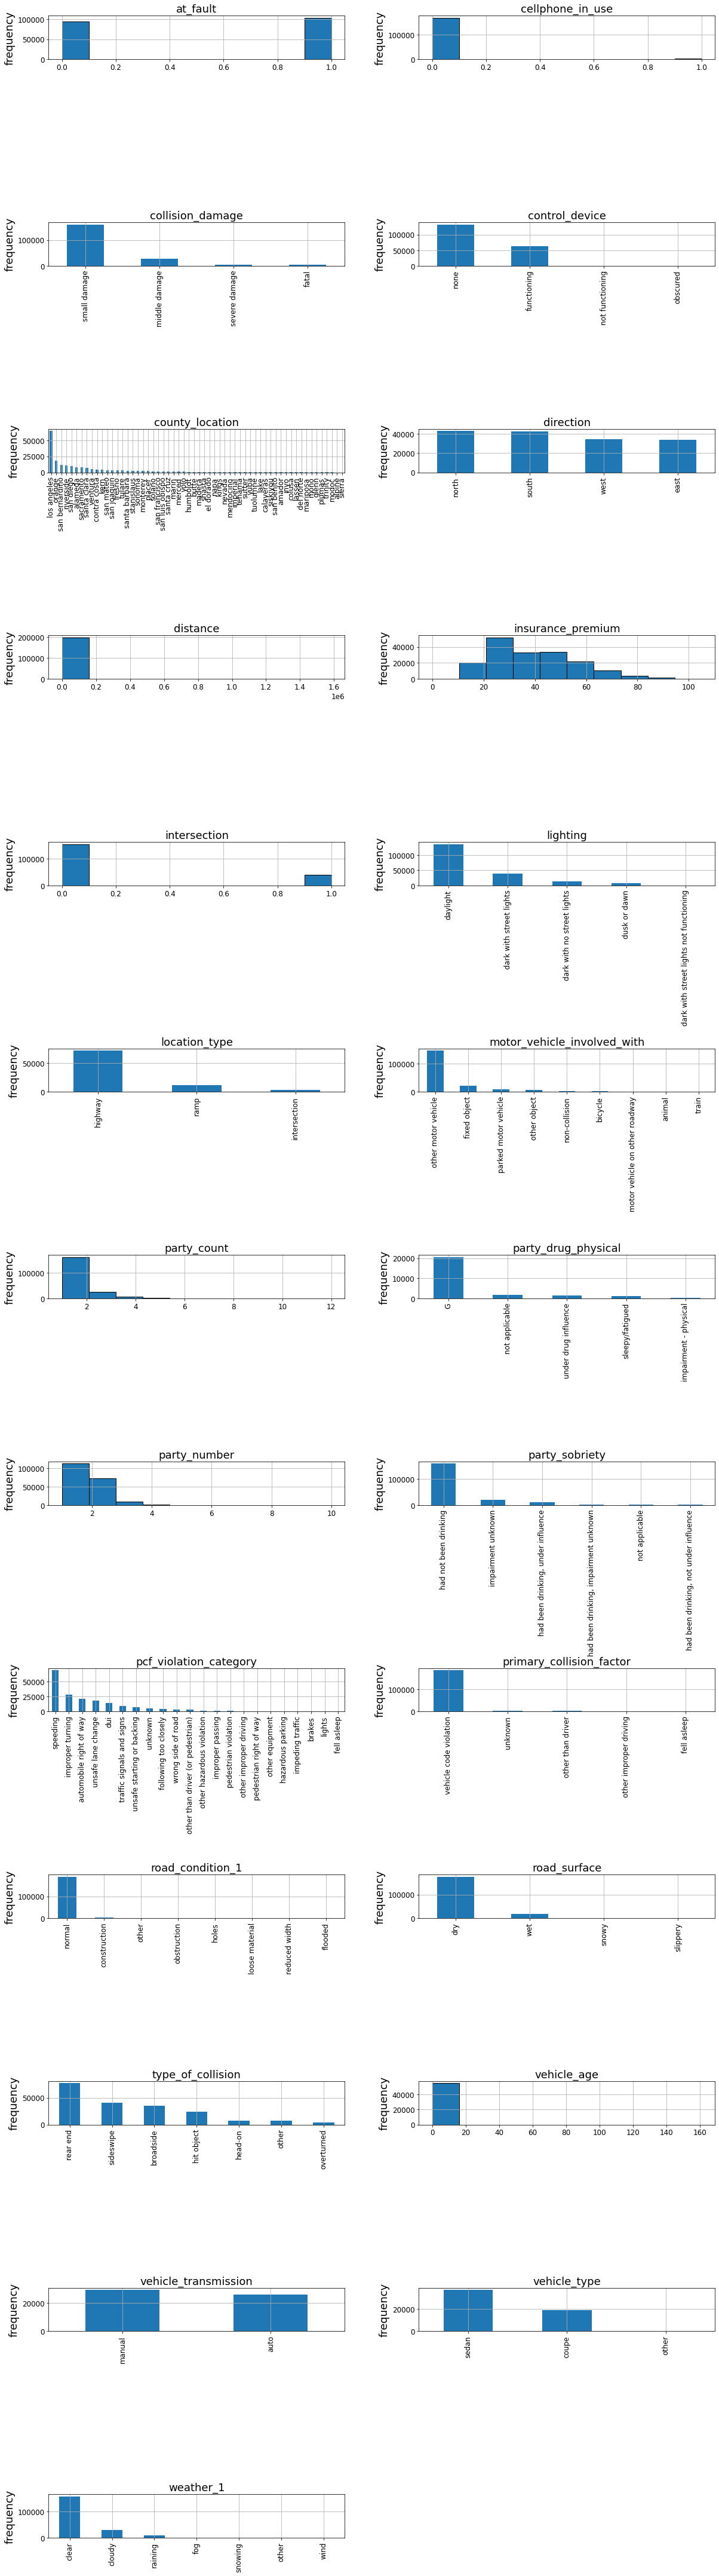

In [23]:
fig = plt.figure(figsize=(20, 84))
plt.subplots_adjust(wspace=0.25, hspace=3.75)

for i, col in enumerate(data.columns.difference(['case_id', 'collision_date', 'collision_time', 'party_type', 'county_city_location'])):
    ax = fig.add_subplot(14, 2, i + 1)
    
    # Отобразим количественные и категориальные переменные соответствующими методами
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col].plot(kind='hist', edgecolor='black')
    else:
        data[col].value_counts().plot(kind='bar')
    
    ax.set_title(col)
    ax.set_ylabel('frequency')
    ax.grid(visible=True)

#### Краткий вывод:
- в данных отсутствуют нарушения правила хорошего стиля в названиях столбцов
- в данных отсутствуют несоответствия типов в столбцах 
- в данных присутствуют явные пропуски в столбцах `direction`, `intersection`, `weather_1`, `location_type`, `primary_collision_factor`, `pcf_violation_category`, `type_of_collision`, `motor_vehicle_involved_with`, `road_surface`, `road_condition_1`, `lighting`, `control_device`, `collision_time`, `insurance_premium`, `party_sobriety`, `party_drug_physical`, `cellphone_in_use`, `vehicle_type`, `vehicle_transmission` и `vehicle_age`
- в данных присутствуют неявные пропуски в столбцах `primary_collision_factor` (`unknown`), `pcf_violation_category` (`unknown`), `party_sobriety` (`impairment unknown`), `party_drug_physical` (`G`)
- в данных присутствуют аномальные значения
- в данных присутствуют намёки на мультиколлинеарность
- в данных были обнаружены очевидные взаимосвязи. Так, например, есть взаимосвязь между погодой `weather_1` и cостоянием дороги	`road_surface`, а также названием географических районов`county_location` или типом аварии `type_of_collision` и типом проезжей частей `intersection`
- в данных отсутствуют намёки на дисбаланс классов в целевом признаке `at_fault` 
- большинство автомобилей не имеют телефона в наличии или возможности разговаривать по громкой связи
- большинство повреждений в авариях незначительны (`small damage`)
- большинство аварий произошли в городе `los angeles`
- большинство аварий произошли на прямой проезжей части, на шоссе (`highway`)
- большинство аварий произошли при дневном свете (`daylight`)
- более $15\%$ аварий имеют более $2$ участников
- трезвых участников больше всего
- большинство аварий происходят по причине превышения скорости (`speeding`)
- основным фактором аварии является нарушение правил ПДД (`vehicle code violation`)
- большинство аварий происходят на сухой дороге (`dry`)
- в большинстве аварий повреждается задняя часть автомобиля (`rear end`)
- большинство автомобилей имеют тип кузова `sedan`
- большинство аварий происходят при ясной погоде (`clear`) 

### Предобработка данных

#### Удалим неинформативные признаки, которые не несут ценности для прогноза:

Удалим столбцы, которые никак не связаны с прогнозированием виновности в ДТП `at_fault`:
- `case_id`
- `party_count`
- `party_number`
- `party_type`

In [24]:
data = data[data.columns.difference(['case_id', 'party_count', 'party_number', 'party_type'])]

Удалим признаки, содержащие информацию, которая не известна до наступления аварии, или когда водитель только сел за руль:
- `collision_damage`
- `collision_date`
- `collision_time`
- `insurance_premium`
- `primary_collision_factor`
- `pcf_violation_category`
- `type_of_collision`
- `motor_vehicle_involved_with`

In [25]:
data = data[data.columns.difference(['collision_damage', 'collision_date', 'collision_time',
                                     'insurance_premium', 'primary_collision_factor', 'pcf_violation_category',
                                     'type_of_collision', 'motor_vehicle_involved_with'])]

В данных присутствуют два похожих друг на друга признака — `county_city_location` и `county_location`. Не смотря на то, что признак `county_city_location` содержит в себе больше полезной информации, оставим только признак `county_location`, так как его размерность намного меньше (всего $58$ уникальных значений)

In [26]:
data = data[data.columns.difference(['county_city_location'])]

Проанализировав таблицу с попарными корреляциями столбцов, можно сделать предположение о линейной независимости целевого признака `at_fault` и признака `direction`. Здравый смысл подсказывает, что между ними вообще нет никакой зависимости

In [27]:
data = data[data.columns.difference(['direction'])]

#### Исправим нарушения правил хорошего стиля в названиях признаков:

В данных отсутствуют нарушения правил хорошего стиля в названиях признаков

#### Исправим несоответствия типов признаков:

В данных отсутствуют несоответствия типов признаков 

#### Очистим данные от дубликатов:

Проверим данные на наличие неявных дубликатов

In [28]:
# check
for col in data.columns:
    if not pd.api.types.is_numeric_dtype(data[col]):
        print(col + ':', data[col].sort_values().unique(), '\n\n')

control_device: ['functioning' 'none' 'not functioning' 'obscured' None] 


county_location: ['alameda' 'alpine' 'amador' 'butte' 'calaveras' 'colusa' 'contra costa'
 'del norte' 'el dorado' 'fresno' 'glenn' 'humboldt' 'imperial' 'inyo'
 'kern' 'kings' 'lake' 'lassen' 'los angeles' 'madera' 'marin' 'mariposa'
 'mendocino' 'merced' 'modoc' 'mono' 'monterey' 'napa' 'nevada' 'orange'
 'placer' 'plumas' 'riverside' 'sacramento' 'san benito' 'san bernardino'
 'san diego' 'san francisco' 'san joaquin' 'san luis obispo' 'san mateo'
 'santa barbara' 'santa clara' 'santa cruz' 'shasta' 'sierra' 'siskiyou'
 'solano' 'sonoma' 'stanislaus' 'sutter' 'tehama' 'trinity' 'tulare'
 'tuolumne' 'ventura' 'yolo' 'yuba'] 


lighting: ['dark with no street lights' 'dark with street lights'
 'dark with street lights not functioning' 'daylight' 'dusk or dawn' None] 


location_type: ['highway' 'intersection' 'ramp' None] 


party_drug_physical: ['G' 'impairment - physical' 'not applicable' 'sleepy/fatigued'
 

Очистим данные от неявных дубликатов в признаке `control_device`

In [29]:
data['control_device'] = data['control_device'].apply(lambda value: None if value == 'none' else value)

Проверим данные на наличие явных дубликатов

In [30]:
# check
data.duplicated().sum()

76569

В результате удаления достаточно большого количества признаков в данных образовалось большое количество явных дубликатов. Удалим их

In [31]:
data.drop_duplicates(inplace=True)

#### Очистим данные от аномальных значений:

Проанализируем признак `distance`

count    120268.0000
mean        856.8501
std       10100.5486
min           0.0000
25%          27.0000
50%         150.0000
75%         528.0000
85%        1056.0000
90%        1600.0000
95%        3168.0000
97.5%      5280.0000
99%       10560.0000
99.5%     15840.0000
max     1584000.0000
Name: distance, dtype: float64

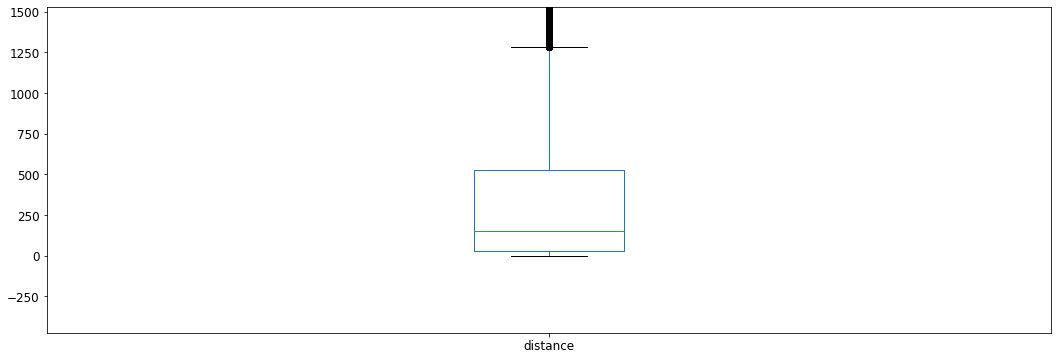

In [32]:
descriptive_stats = data['distance'].describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.975, 0.99, 0.995])
interquartile_range = descriptive_stats['75%'] - descriptive_stats['25%']

display(descriptive_stats)
data['distance'].plot(kind='box', ylim=(descriptive_stats['25%'] - interquartile_range, descriptive_stats['75%'] + interquartile_range * 2));

Проанализируем признак `vehicle_age`

In [33]:
data['vehicle_age'].value_counts().sort_index()

0.0000      2689
1.0000      2201
2.0000      5238
3.0000      9392
4.0000      6257
5.0000      4929
6.0000      3528
7.0000      3457
8.0000      3166
9.0000      2489
10.0000     1804
11.0000     1285
12.0000      833
13.0000      517
14.0000      268
15.0000       35
16.0000        6
17.0000        3
19.0000        1
161.0000       2
Name: vehicle_age, dtype: int64

Удалим аномальные значения

In [34]:
data = data[(data['distance'] <= data['distance'].quantile(0.975)) & ((data['vehicle_age'] <= 20) | (data['vehicle_age'].isna()))]

#### Создадим  pipeline с предобработкой данных:

- для того чтобы не увеличивать размерность данных слишком сильно будем использовать технику кодирования `OneHotEncoding` только для бинарных категориальных признаков (`cellphone_in_use`, `intersection`, `vehicle_transmission`, `vehicle_type`)
- остальные категориальные признаки закодируем техникой `OrdinalEncoding`
- будем использовать `StandardScaler` для скалирования количественных переменных (`distance`, `vehicle_age`)
- будем заполнять пропуски при помощи `IterativeImputer`

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_onehot', OneHotEncoder(), ['cellphone_in_use', 'intersection', 'vehicle_transmission', 'vehicle_type']),
        ('categorical_ordinal', OrdinalEncoder(), ['control_device', 'county_location', 'lighting', 'location_type',
                                                   'party_drug_physical', 'party_sobriety', 'road_condition_1', 'road_surface',
                                                   'weather_1']),
        ('numerical', StandardScaler(), ['distance', 'vehicle_age'])
    ],
    remainder='passthrough'
)
preprocessor = Pipeline(steps=[('preprocessor', preprocessor), ('imputer', IterativeImputer())])
preprocessor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_onehot',
                                                  OneHotEncoder(),
                                                  ['cellphone_in_use',
                                                   'intersection',
                                                   'vehicle_transmission',
                                                   'vehicle_type']),
                                                 ('categorical_ordinal',
                                                  OrdinalEncoder(),
                                                  ['control_device',
                                                   'county_location',
                                                   'lighting', 'location_type',
                                                   'party_drug_physical',
                                                   'party_sobriety',
                                                   'road_condition_1',
                                                   'road_surface',
                                                   'weather_1']),
                                                 ('numerical', StandardScaler(),
                                                  ['distance',
                                                   'vehicle_age'])])),
                ('imputer', IterativeImputer())])

#### Подготовим обучающую, валидационную и тестовую выборки:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['at_fault'], axis=1),
                                                    data['at_fault'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=data['at_fault'],
                                                    random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.25,
                                                      shuffle=True,
                                                      stratify=y_train,
                                                      random_state=RANDOM_STATE)

In [37]:
# check
for dataset in [X_train, X_valid, X_test]:
    print(f'{len(dataset) / len(data) * 100}%')

60.0%
20.0%
20.0%


#### Краткий вывод:
- в данных практически отсутствовали неявные дубликаты, но из-за удаления большого количества столбцов появилось очень много явных дубликатов

## Исследовательский анализ данных

#### Исследуем дисбаланс классов в целевом признаке `at_fault`:

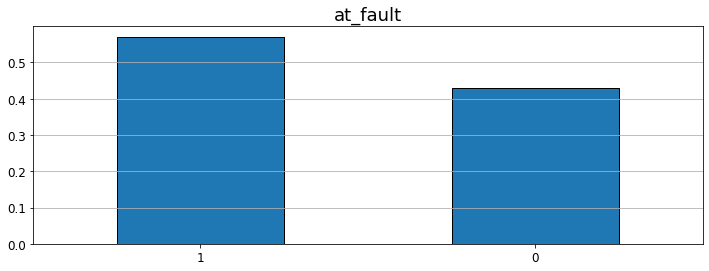

In [38]:
data['at_fault'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 4), rot=0, edgecolor='black', title='at_fault').grid(axis='y')

После этапа предобработки данных в целевом признаке `at_fault` образовался незначительный дисбаланс классов

#### Исследуем линейную зависимость между целевым признаком `at_fault` и остальными признаками:

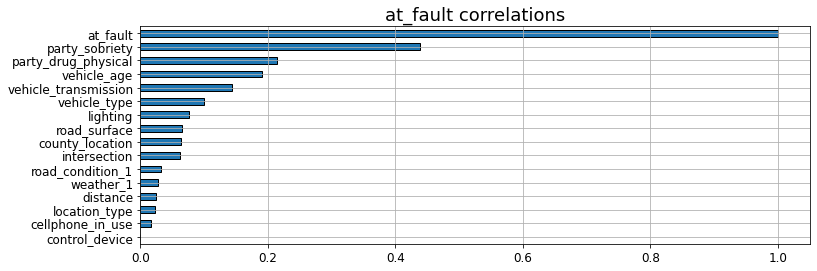

In [39]:
phik_overview = data.phik_matrix(interval_cols=['distance', 'vehicle_age'])['at_fault'].sort_values()
phik_overview.plot(kind='barh', figsize=(12, 4), edgecolor='black', title='at_fault correlations', grid=True);

#### Краткий вывод:
- после этапа предобработки данных в целевом признаке `at_fault` образовался незначительный дисбаланс классов
- можно предположить, что существует значимая взаимосвязь между целевым признаком `at_fault` и трезвостью участника аварии `party_sobriety`, а также другими признаками

<a name="best-model-search"></a>
### Шаг 5. Поиск лучшей модели и анализ важности факторов ДТП

Рассмотрим следующие метрики оценки качества модели:
- `Recall`
- `Precision`
- `F-beta score`
- `Accuracy`

В нашей задаче очень важны ошибки $2$-го рода (`false negative`), так как для каршеринговой компании в первую очередь важно минимизировать число аварий. В тоже самое время достаточно большое количество ошибок $1$-го рода (`false positive`) может привести к оттоку клиентов. Если отказать клиенту в поездке из-за потенциальной возможности аварии, то он может расстроиться и вовсе перестать пользоваться услугами каршеринговой компании. Метрика качества `F-beta score` позволяет учитывать ошибки $1$-го и $2$-го рода одновременно с разным весом. Метрика качества `Accuracy` достаточно неплохо подходит для задач с сбалансированными классами в целевом признаке, а также может быть легко интерпретируема и объяснена заказчику. Будем использовать две метрики качества одновременно:
- `F-beta score` с коэффициентом $\beta$ равным $2$ для того, чтобы придать чуть больший вес ошибкам второго рода, (лучше всё-таки потерять клиента, но предотвратить аварию)

- `Accuracy`

#### Создадим и обучим наивную модель, с которой начнём поиск наилучшей модели прогнозирования:

In [40]:
dummy_model = Pipeline(steps=[('preprocessor', preprocessor), ('dummy_classifier',  DummyClassifier(strategy='prior', random_state=RANDOM_STATE))], memory='tmp/cache')
dummy_model.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:408: UserWarning: Persisting input arguments took 2.52s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='tmp/cache',
         steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical_onehot',
                                                                   OneHotEncoder(),
                                                                   ['cellphone_in_use',
                                                                    'intersection',
                                                                    'vehicle_transmission',
                                                                    'vehicle_type']),
                                                                  ('categorical_ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['control_device',
                                                                    'county_location',
                                                                    'lighting',
                                                                    'location_type',
                                                                    'party_drug_physical',
                                                                    'party_sobriety',
                                                                    'road_condition_1',
                                                                    'road_surface',
                                                                    'weather_1']),
                                                                  ('numerical',
                                                                   StandardScaler(),
                                                                   ['distance',
                                                                    'vehicle_age'])])),
                                 ('imputer', IterativeImputer())])),
                ('dummy_classifier', DummyClassifier(random_state=144210))])

#### Проанализируем предсказания наивной модели на валидационной выборке: 

In [41]:
dummy_results = pd.DataFrame([[accuracy_score(y_valid, dummy_model.predict(X_valid)), fbeta_score(y_valid, dummy_model.predict(X_valid), beta=2)]],
                           index=['DummyClassifier'],
                           columns=['accuracy', 'f2 score'])
dummy_results.index.name='params_classifier'
dummy_results

,accuracy,f2 score
params_classifier,,
DummyClassifier,0.5709,0.8693


####  Смоделируем несколько моделей с перебором гиперпараметров:

Будем использовать следующие модели:
- DecisionTreeClassifier
- RandomForestClassifier
- LGBMClassifier  

In [42]:
classifier_names = ['DecisionTreeClassifier', 'RandomForestClassifier', 'LGBMClassifier']

def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', classifier_names)
    
    if classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_categorical('decision_tree_classifier__max_depth', [2**i for i in range(1, 11)]),
            'min_samples_split': trial.suggest_categorical('decision_tree_classifier__min_samples_split', [2**i for i in range(1, 13)])
        }
        classifier_obj = DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    elif classifier_name == 'RandomForestClassifier':
        params = {
            'max_depth': trial.suggest_categorical('random_forest_classifier__max_depth', [2**i for i in range(1, 11)]),
            'min_samples_split': trial.suggest_categorical('random_forest_classifier__min_samples_split', [2**i for i in range(1, 11)]),
            'max_leaf_nodes': trial.suggest_categorical('random_forest_classifier__max_leaf_nodes', [2**i for i in range(1, 11)])
        }
        classifier_obj = RandomForestClassifier(**params, random_state=RANDOM_STATE)
    elif classifier_name == 'LGBMClassifier':
        params = {
            'num_leaves': trial.suggest_categorical('lgbm_classifier__num_leaves', [2**i for i in range(1, 11)]),
            'learning_rate': trial.suggest_categorical('lgbm_classifier__learning_rate', [10**(-i) for i in range(1, 4)]),
            'max_depth': trial.suggest_categorical('lgbm_classifier__max_depth', [2**i for i in range(1, 11)]),
            'n_estimators': trial.suggest_categorical('lgbm_classifier__n_estimators', [2**i for i in range(1, 11)]),
        }
        classifier_obj = LGBMClassifier(**params, random_state=RANDOM_STATE)        

    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier_obj)], memory='tmp/cache')
    pipeline.fit(X_train, y_train)
    return accuracy_score(y_valid, pipeline.predict(X_valid)), fbeta_score(y_valid, pipeline.predict(X_valid), beta=2)

study = optuna.create_study(directions=['maximize', 'maximize'], sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=200)

[I 2024-03-29 17:14:46,209] A new study created in memory with name: no-name-83bd80e6-19f6-4896-8baf-da5e8b8ebd2a
[I 2024-03-29 17:14:53,510] Trial 0 finished with values: [0.6299262920199395, 0.6472469832029591] and parameters: {'classifier': 'LGBMClassifier', 'lgbm_classifier__num_leaves': 64, 'lgbm_classifier__learning_rate': 0.1, 'lgbm_classifier__max_depth': 32, 'lgbm_classifier__n_estimators': 64}. 
[I 2024-03-29 17:14:56,500] Trial 1 finished with values: [0.5937966000596481, 0.4073818500067322] and parameters: {'classifier': 'DecisionTreeClassifier', 'decision_tree_classifier__max_depth': 2, 'decision_tree_classifier__min_samples_split': 128}. 
[I 2024-03-29 17:15:02,919] Trial 2 finished with values: [0.6224276767074262, 0.7693935716906058] and parameters: {'classifier': 'RandomForestClassifier', 'random_forest_classifier__max_depth': 64, 'random_forest_classifier__min_samples_split': 1024, 'random_forest_classifier__max_leaf_nodes': 32}. 
[I 2024-03-29 17:15:06,304] Trial 3 f

####  Проанализируем результаты моделирования и выберем наилучшую модель:

In [50]:
results = study.trials_dataframe()
results.head()

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_classifier,params_decision_tree_classifier__max_depth,params_decision_tree_classifier__min_samples_split,params_lgbm_classifier__learning_rate,params_lgbm_classifier__max_depth,params_lgbm_classifier__n_estimators,params_lgbm_classifier__num_leaves,params_random_forest_classifier__max_depth,params_random_forest_classifier__max_leaf_nodes,params_random_forest_classifier__min_samples_split,state
0,0,0.6299,0.6472,2024-03-29 17:14:46.210722,2024-03-29 17:14:53.510616,0 days 00:00:07.299894,LGBMClassifier,NaN,NaN,0.1000,32.0000,64.0000,64.0000,NaN,NaN,NaN,COMPLETE
1,1,0.5938,0.4074,2024-03-29 17:14:53.511780,2024-03-29 17:14:56.500478,0 days 00:00:02.988698,DecisionTreeClassifier,2.0000,128.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.6224,0.7694,2024-03-29 17:14:56.591092,2024-03-29 17:15:02.919178,0 days 00:00:06.328086,RandomForestClassifier,NaN,NaN,NaN,NaN,NaN,NaN,64.0000,32.0000,1024.0000,COMPLETE
3,3,0.5747,0.6264,2024-03-29 17:15:02.920318,2024-03-29 17:15:06.303949,0 days 00:00:03.383631,DecisionTreeClassifier,512.0000,64.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.6340,0.6565,2024-03-29 17:15:06.305116,2024-03-29 17:15:22.507130,0 days 00:00:16.202014,LGBMClassifier,NaN,NaN,0.0100,4.0000,512.0000,128.0000,NaN,NaN,NaN,COMPLETE


Категоризируем каждый шаг оптимизации в зависимости от классификатора 

In [51]:
classifier_study = {}
for classifier_name in classifier_names:    
    classifier_study[classifier_name] = optuna.create_study(directions=['maximize', 'maximize'])
    classifier_study[classifier_name].add_trials([optuna.trial.create_trial(params=trial.params, distributions=trial.distributions, values=trial.values) 
                                                  for trial in study.get_trials(deepcopy=False) if trial.params['classifier'] == classifier_name])
    
for classifier_name in classifier_study:
    display(classifier_study[classifier_name].trials_dataframe().head())

[I 2024-03-29 18:08:52,959] A new study created in memory with name: no-name-6c7fe75d-fc71-45de-bd85-ab6d98116d4b
[I 2024-03-29 18:08:52,968] A new study created in memory with name: no-name-e1b42a50-2b84-4996-a21e-3ee0fb6d9723
[I 2024-03-29 18:08:52,986] A new study created in memory with name: no-name-e15614c0-b5f3-49aa-856f-e8bf62845f5a


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_classifier,params_decision_tree_classifier__max_depth,params_decision_tree_classifier__min_samples_split,state
0,0,0.5938,0.4074,2024-03-29 18:08:52.961627,2024-03-29 18:08:52.961627,0 days,DecisionTreeClassifier,2,128,COMPLETE
1,1,0.5747,0.6264,2024-03-29 18:08:52.961800,2024-03-29 18:08:52.961800,0 days,DecisionTreeClassifier,512,64,COMPLETE
2,2,0.5287,0.5772,2024-03-29 18:08:52.961973,2024-03-29 18:08:52.961973,0 days,DecisionTreeClassifier,64,16,COMPLETE
3,3,0.6125,0.4902,2024-03-29 18:08:52.962180,2024-03-29 18:08:52.962180,0 days,DecisionTreeClassifier,4,64,COMPLETE
4,4,0.6335,0.6407,2024-03-29 18:08:52.962344,2024-03-29 18:08:52.962344,0 days,DecisionTreeClassifier,8,1024,COMPLETE


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_classifier,params_random_forest_classifier__max_depth,params_random_forest_classifier__max_leaf_nodes,params_random_forest_classifier__min_samples_split,state
0,0,0.6224,0.7694,2024-03-29 18:08:52.969648,2024-03-29 18:08:52.969648,0 days,RandomForestClassifier,64,32,1024,COMPLETE
1,1,0.6251,0.7401,2024-03-29 18:08:52.969904,2024-03-29 18:08:52.969904,0 days,RandomForestClassifier,32,64,8,COMPLETE
2,2,0.6224,0.7694,2024-03-29 18:08:52.970107,2024-03-29 18:08:52.970107,0 days,RandomForestClassifier,64,32,1024,COMPLETE
3,3,0.6180,0.7881,2024-03-29 18:08:52.970334,2024-03-29 18:08:52.970334,0 days,RandomForestClassifier,8,8,256,COMPLETE
4,4,0.6180,0.7881,2024-03-29 18:08:52.970580,2024-03-29 18:08:52.970580,0 days,RandomForestClassifier,8,8,256,COMPLETE


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_classifier,params_lgbm_classifier__learning_rate,params_lgbm_classifier__max_depth,params_lgbm_classifier__n_estimators,params_lgbm_classifier__num_leaves,state
0,0,0.6299,0.6472,2024-03-29 18:08:52.987406,2024-03-29 18:08:52.987406,0 days,LGBMClassifier,0.1000,32,64,64,COMPLETE
1,1,0.6340,0.6565,2024-03-29 18:08:52.987664,2024-03-29 18:08:52.987664,0 days,LGBMClassifier,0.0100,4,512,128,COMPLETE
2,2,0.5709,0.8693,2024-03-29 18:08:52.987913,2024-03-29 18:08:52.987913,0 days,LGBMClassifier,0.0010,2,2,4,COMPLETE
3,3,0.6289,0.6514,2024-03-29 18:08:52.988124,2024-03-29 18:08:52.988124,0 days,LGBMClassifier,0.1000,128,256,16,COMPLETE
4,4,0.5709,0.8693,2024-03-29 18:08:52.988353,2024-03-29 18:08:52.988353,0 days,LGBMClassifier,0.0010,2,2,4,COMPLETE


In [52]:
# Функция строит набор графиков в зависимости от классификатора
def generate_plot(study):
    params = [col[7:] for col in study.trials_dataframe().columns if col != 'params_classifier' and col.startswith('params')]
    accuracy_fig = optuna.visualization.plot_slice(study, target=lambda t: t.values[0], target_name='Accuracy', params=params)
    f2_score_fig = optuna.visualization.plot_slice(study, target=lambda t: t.values[1], target_name='F2 score', params=params)
    pareto_fig = optuna.visualization.plot_pareto_front(study, target_names=['Accuracy', 'F2 score'])
    
    accuracy_fig.show()
    f2_score_fig.show()
    pareto_fig.show()

In [53]:
generate_plot(classifier_study['DecisionTreeClassifier'])

In [54]:
generate_plot(classifier_study['RandomForestClassifier'])

In [55]:
generate_plot(classifier_study['LGBMClassifier'])

По анализу графика Парето `Accuracy` и `F2 score` для каждого классификатора отберём наилучшую модель

In [57]:
best_trials = pd.DataFrame(data=[classifier_study['DecisionTreeClassifier'].trials_dataframe().loc[7],
                                 classifier_study['RandomForestClassifier'].trials_dataframe().loc[31],
                                 classifier_study['LGBMClassifier'].trials_dataframe().loc[100]])
display(pd.concat([dummy_results,
                   best_trials[['values_0', 'values_1', 'params_classifier']]
                   .rename(columns={'values_0': 'accuracy', 'values_1': 'f2 score'})
                   .set_index('params_classifier')]))
_ = best_trials.apply(lambda row: display(row.drop(['values_0', 'values_1', 'number', 'datetime_start', 'datetime_complete', 'duration', 'state']).dropna()), axis=1)

,accuracy,f2 score
params_classifier,,
DummyClassifier,0.5709,0.8693
DecisionTreeClassifier,0.6287,0.6489
RandomForestClassifier,0.6176,0.7940
LGBMClassifier,0.6176,0.8185


params_classifier                                     DecisionTreeClassifier
params_decision_tree_classifier__max_depth                         1024.0000
params_decision_tree_classifier__min_samples_split                 4096.0000
Name: 7, dtype: object

params_classifier                                     RandomForestClassifier
params_random_forest_classifier__max_depth                            4.0000
params_random_forest_classifier__max_leaf_nodes                      32.0000
params_random_forest_classifier__min_samples_split                 1024.0000
Name: 31, dtype: object

params_classifier                        LGBMClassifier
params_lgbm_classifier__learning_rate            0.1000
params_lgbm_classifier__max_depth               64.0000
params_lgbm_classifier__n_estimators             8.0000
params_lgbm_classifier__num_leaves              32.0000
Name: 100, dtype: object

В качестве наилучшей модели выберем `LGBMClassifier` со следующими параметрами

In [58]:
best_params=best_trials.iloc[-1].rename({'params_lgbm_classifier__learning_rate': 'learning_rate',
                                         'params_lgbm_classifier__max_depth': 'max_depth',
                                         'params_lgbm_classifier__n_estimators': 'n_estimators',
                                         'params_lgbm_classifier__num_leaves': 'num_leaves'})[['learning_rate', 'max_depth', 'n_estimators', 'num_leaves']]
best_params[['max_depth', 'n_estimators', 'num_leaves']] = best_params[['max_depth', 'n_estimators', 'num_leaves']].astype('int64')
best_params

learning_rate   0.1000
max_depth           64
n_estimators         8
num_leaves          32
Name: 100, dtype: object

#### Краткий вывод:
- среди обученных моделей `LGBMClassifier` показала наилучшие результаты
- наилучшая модель `LGBMClassifier` показала результаты ненамного лучше, чем наивная модель `DummyClassifier`

<a name="best-model-test"></a>
### Шаг 6. Проверка лучшей модели в работе

#### Обучим наилучшую модель на обучающей и валидационной выборках:

In [59]:
classifier = LGBMClassifier(**best_params)   
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)], memory='tmp/cache')
pipeline.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
pipeline

/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py:408: UserWarning:

Persisting input arguments took 3.12s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.



Pipeline(memory='tmp/cache',
         steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical_onehot',
                                                                   OneHotEncoder(),
                                                                   ['cellphone_in_use',
                                                                    'intersection',
                                                                    'vehicle_transmission',
                                                                    'vehicle_type']),
                                                                  ('categorical_ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['control_device',
                                                                    'county_location',
                                                                    'lighting',
                                                                    'location_type',
                                                                    'party_drug_physical',
                                                                    'party_sobriety',
                                                                    'road_condition_1',
                                                                    'road_surface',
                                                                    'weather_1']),
                                                                  ('numerical',
                                                                   StandardScaler(),
                                                                   ['distance',
                                                                    'vehicle_age'])])),
                                 ('imputer', IterativeImputer())])),
                ('classifier',
                 LGBMClassifier(max_depth=64, n_estimators=8, num_leaves=32))])

#### Протестируем наилучшую модель на тестовой выборке:

In [60]:
y_pred = pipeline.predict(X_test)
pd.DataFrame([[accuracy_score(y_test, y_pred), fbeta_score(y_valid, y_pred, beta=2)]],
               index=['LGBMClassifier'],
               columns=['accuracy', 'f2 score'])

,accuracy,f2 score
LGBMClassifier,0.6233,0.7542


#### Проведём графический анализ:

In [61]:
recall_score(y_test, y_pred)

0.8904477611940298

In [62]:
precision_score(y_test, y_pred)

0.6180782180782181

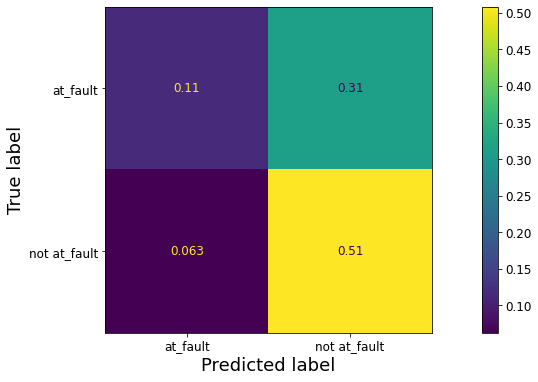

In [63]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,
                                                         y_pred,
                                                         normalize='all'),
                                                         display_labels=['at_fault', 'not at_fault']).plot();

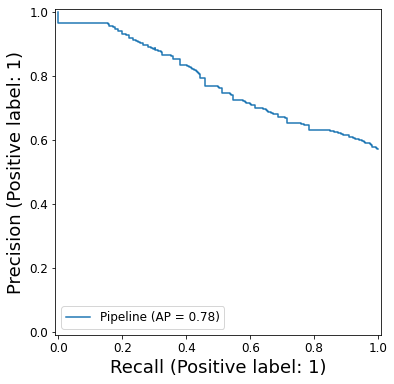

In [64]:
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test);

#### Проанализируем важность основных факторов, влияющих на вероятность ДТП, по мнению наилучшей модели:

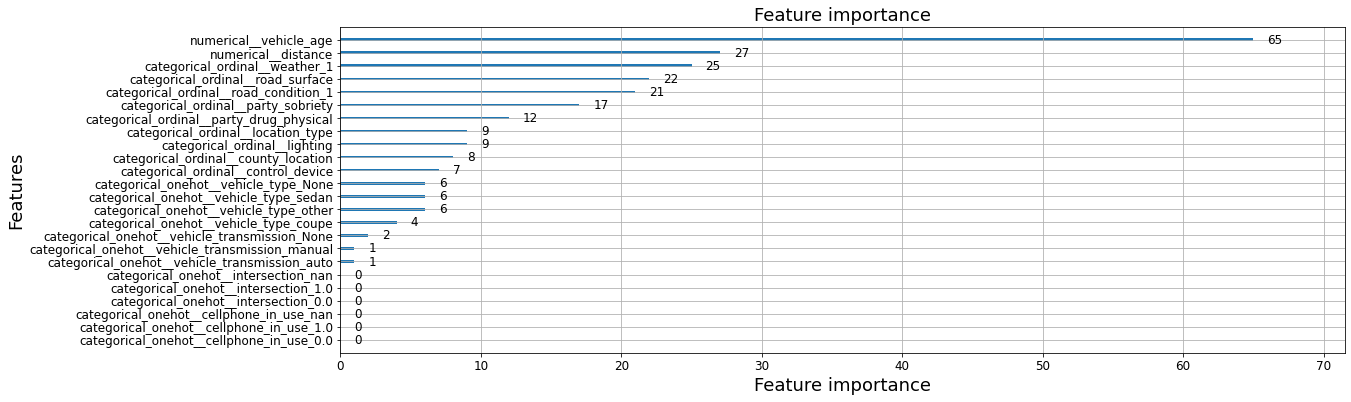

In [65]:
ax = plot_importance(classifier, ignore_zero=False)
ax.set_yticklabels(pipeline[:-1].get_feature_names_out());

#### Проанализируем зависимость целевого признака `at_fault` от возраст автомобиля в годах `vehicle_age`:

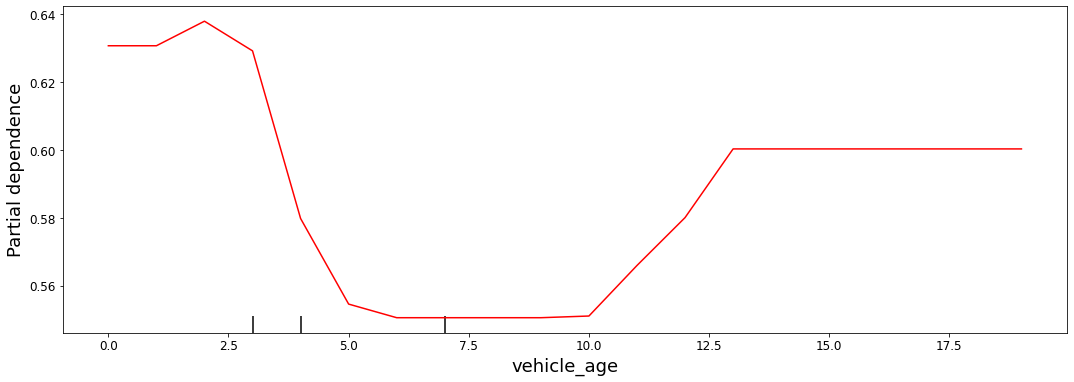

In [66]:
PartialDependenceDisplay.from_estimator(pipeline, X_train, ['vehicle_age'], line_kw={"color": "red"});

Можно заметить, что слишком старые, либо наоборот слишком новые автомобили чаще попадают в аварии. По крайней мере так считает наилучшая модель. В данном случае можно предложить более тщательный осмотр автомобилей каршеринговой компании, которые имеют возраст менее $5$ или более $10$ лет 

<a name="general-conclusion"></a>
### Шаг 7. Выводы

- в результате моделирования была отобрана наилучшая модель — `LGBMClassifier`
- наилучшая модель `LGBMClassifier` показала результаты не намного лучше, чем наивная модель `DummyClassifier`. Скорее всего это связано с тем, что сама задача прогнозирования виновности водителя в ДТП принадлежит к классу задач с низким соотношением сигнала к шуму. Виновность водителя в ДТП зависит от слишком большого количества факторов
- возможно каршеринговой компании вообще стоит отказаться от прогнозирования и подумать над другими способами уменьшения числа аварий